# Credit Card Fraud Detection Model
### Krishnaprasad Seshadri | Data Analyst Portfolio Project

## Overview
This project builds an end-to-end fraud detection model using a real world dataset 
of 284,807 credit card transactions, of which only 0.17% are fraudulent.

The core challenge is severe class imbalance — a naive model predicting everything 
as legitimate would achieve 99.83% accuracy but be completely useless. This project 
addresses that using SMOTE oversampling and evaluates performance using metrics 
appropriate for imbalanced datasets.

## Key Results
- **ROC AUC Score:** 0.9644
- **Fraud Recall:** 83%
- **Fraud Precision:** 83%
- **Dataset Size:** 284,807 transactions

## Tools Used
- Python (Pandas, NumPy, Scikit-learn, Imbalanced-learn)
- Matplotlib & Seaborn for visualisation
- Jupyter Notebook

## Step 1 — Import Libraries
We import the necessary Python libraries for data manipulation, visualisation, 
and machine learning before loading the dataset.

In [1]:
import subprocess
subprocess.run(["pip", "install", "pandas", "numpy", "matplotlib", 
                "seaborn", "scikit-learn", "imbalanced-learn"])

CompletedProcess(args=['pip', 'install', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'imbalanced-learn'], returncode=0)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

print("All libraries loaded successfully!")

All libraries loaded successfully!


## Step 2 — Load and Explore the Dataset
We load the dataset and take an initial look at its size and structure. 
The dataset contains 284,807 transactions with 31 columns.

In [3]:
# Load the dataset
df = pd.read_csv('../data/creditcard.csv')

# How big is it?
print("Rows and columns:", df.shape)

# Look at the first 5 rows
df.head()

Rows and columns: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 3 — Analyse Class Imbalance
We examine the ratio of fraudulent to legitimate transactions. 
This is the central challenge of the project.

In [4]:
# How many fraud vs legitimate transactions are there?
fraud_count = df['Class'].value_counts()
print(fraud_count)

# Show it as a percentage
print("\nFraud percentage:", round(df['Class'].mean() * 100, 2), "%")

Class
0    284315
1       492
Name: count, dtype: int64

Fraud percentage: 0.17 %


## Step 4 — Visualise Class Imbalance
A bar chart makes the imbalance immediately obvious and communicates 
the problem clearly to non-technical stakeholders.

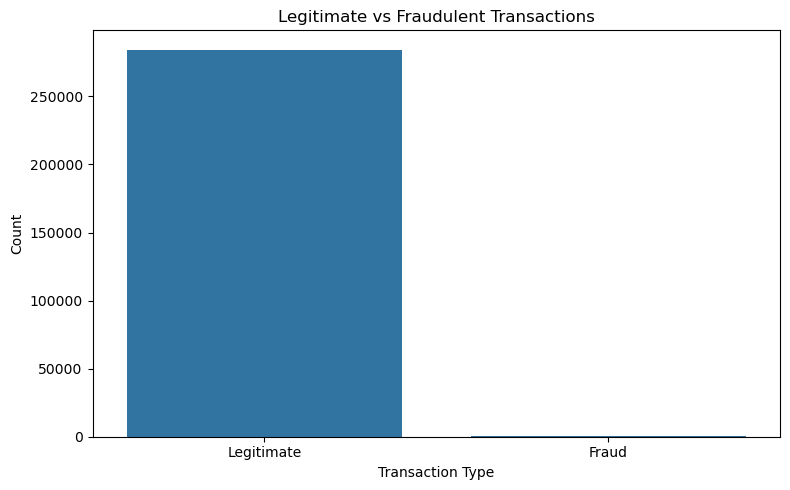

In [5]:
# Visualise the class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df)
plt.title('Legitimate vs Fraudulent Transactions')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Step 5 — Analyse Transaction Amounts
We compare average transaction amounts between fraud and legitimate cases 
to uncover behavioural patterns in fraudulent activity.

In [6]:
# Separate fraud and legitimate transactions
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

# Compare transaction amounts
print("Average fraudulent transaction amount: £", round(fraud['Amount'].mean(), 2))
print("Average legitimate transaction amount: £", round(legit['Amount'].mean(), 2))
print("Max fraudulent transaction amount: £", round(fraud['Amount'].max(), 2))
print("Max legitimate transaction amount: £", round(legit['Amount'].max(), 2))

Average fraudulent transaction amount: £ 122.21
Average legitimate transaction amount: £ 88.29
Max fraudulent transaction amount: £ 2125.87
Max legitimate transaction amount: £ 25691.16


## Step 6 — Visualise Amount Distribution
A histogram shows how transaction amounts are distributed across 
both classes, confirming the low and slow fraud pattern.

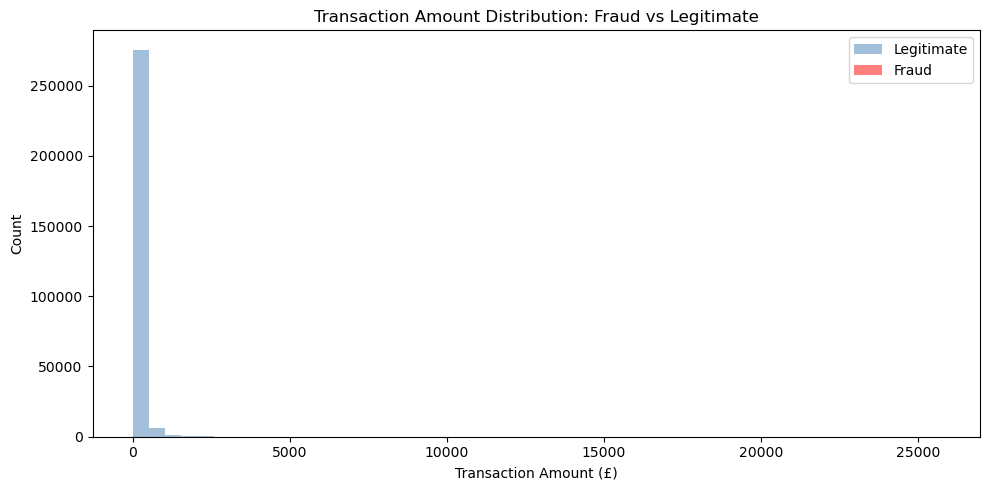

In [7]:
# Visualise transaction amounts for fraud vs legitimate
plt.figure(figsize=(10, 5))
plt.hist(legit['Amount'], bins=50, alpha=0.5, label='Legitimate', color='steelblue')
plt.hist(fraud['Amount'], bins=50, alpha=0.5, label='Fraud', color='red')
plt.title('Transaction Amount Distribution: Fraud vs Legitimate')
plt.xlabel('Transaction Amount (£)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## Step 7 — Prepare Data for Modelling
We separate features from the target variable and split the data 
into 80% training and 20% testing sets using stratified sampling 
to preserve the fraud ratio in both sets.


In [8]:
# Separate features (X) from the target (y)
X = df.drop('Class', axis=1)  # Everything except the Class column
y = df['Class']               # Just the Class column

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("\nFraud cases in training set:", y_train.sum())
print("Fraud cases in test set:", y_test.sum())

Training set size: (227845, 30)
Testing set size: (56962, 30)

Fraud cases in training set: 394
Fraud cases in test set: 98


## Step 8 — Apply SMOTE
We apply Synthetic Minority Oversampling Technique exclusively to the 
training data to balance the classes. The test set remains untouched 
to ensure honest evaluation against real world conditions.

In [9]:
# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print("Legitimate:", sum(y_train == 0))
print("Fraud:", sum(y_train == 1))

print("\nAfter SMOTE:")
print("Legitimate:", sum(y_train_smote == 0))
print("Fraud:", sum(y_train_smote == 1))

C:\Users\krish\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\krish\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\krish\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\krish\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^

Before SMOTE:
Legitimate: 227451
Fraud: 394

After SMOTE:
Legitimate: 227451
Fraud: 227451


## Step 9 — Train Random Forest Model
We train a Random Forest classifier of 100 decision trees on the 
SMOTE balanced training data. Random Forest is chosen for its 
robustness, resistance to overfitting, and ability to produce 
feature importance scores.

In [ ]:
# Build and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

print("Model trained successfully!")

## Step 10 — Evaluate Model Performance
We evaluate the model on the unseen test set using precision, recall 
and F1 score. We focus on the fraud row specifically as overall 
accuracy is a misleading metric on imbalanced datasets.

In [ ]:
# Test the model on unseen data
y_pred = rf_model.predict(X_test)

# Print the results
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

## Step 11 — Confusion Matrix
The confusion matrix shows the raw numbers behind the classification 
report, making it easier to communicate results to non-technical stakeholders.

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix — Fraud Detection Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## Step 12 — Feature Importance
We identify which features the model relied on most when classifying 
transactions. In a real deployment this helps fraud analysts prioritise 
investigations and helps compliance teams explain model decisions to regulators.

In [ ]:
# Feature importance
feature_importance = pd.Series(
    rf_model.feature_importances_, 
    index=X.columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='Blues_r')
plt.title('Top 10 Most Important Features in Fraud Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Step 13 — ROC AUC Score
The ROC AUC score measures the model's overall ability to distinguish 
between fraud and legitimate transactions. A score above 0.90 is 
considered strong in the industry.

In [ ]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print("ROC AUC Score:", round(roc_auc, 4))

## Conclusion
This project demonstrates an end-to-end fraud detection pipeline handling 
the key challenge of class imbalance using SMOTE. The final model achieves 
a ROC AUC score of 0.9644 and 83% recall on fraudulent transactions, 
meaning it correctly identifies 83% of all fraud cases in unseen data.

In a real deployment the 17% of missed fraud cases would be flagged for 
manual review rather than ignored, ensuring no fraud goes completely unaddressed.

**GitHub:** https://github.com/kris-sesh/fraud-detection-fintech